# PyMC3 sampling

This notebook illustrates how pymc3 can be used with an arbitrary (in our case: AMICI) log likelihood function in pyPESTO.

We start by defining the parameterization problem as a `pypesto.Problem`.

In [1]:
import pypesto
import petab
import pymc3 as pm

# import to petab
petab_problem = petab.Problem.from_yaml(
    "conversion_reaction/conversion_reaction.yaml")
# import to pypesto
importer = pypesto.PetabImporter(petab_problem)
# create problem
problem = importer.create_problem()

We create a `pypesto.Pymc3Sampler` object, to which we can pass sampling options.

In [2]:
options = {'draws': 500, 'chains': 2}
sampler = pypesto.Pymc3Sampler(options, return_native=True)

We perform sampling by calling `pypesto.sample` with the problem and the sampler.

In [3]:
result = pypesto.sample(problem, sampler)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k2, k1]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [01:00<00:00, 32.96draws/s]
The acceptance probability does not match the target. It is 0.9080972770822288, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795075797576686, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


That's it. Now we can analyze the obtained results. Here, we use PyMC3's native plotting routines.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b9e72ccd0>,
      dtype=object)

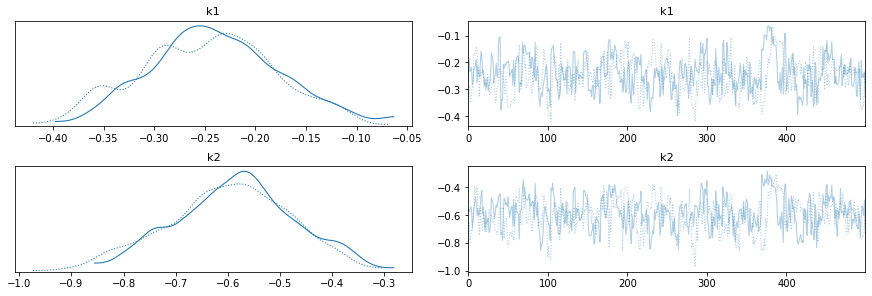

In [4]:
trace = result.sample_result
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b9c07a590>,
      dtype=object)

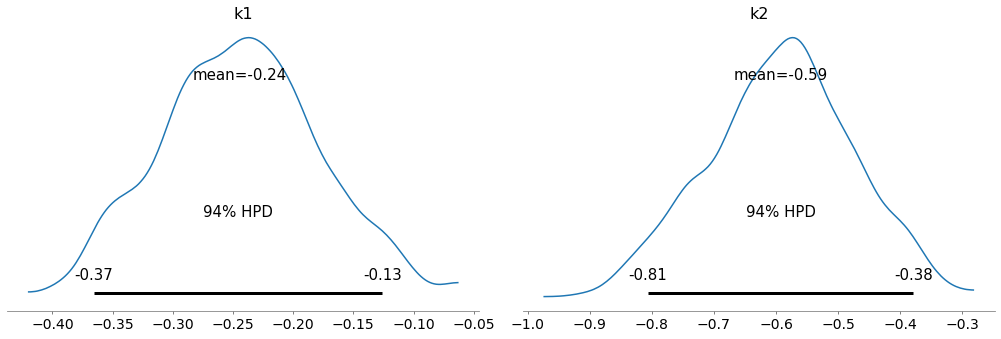

In [5]:
pm.plot_posterior(trace)